# Gaertner L116A Ellipsometer

**Scott Prahl**

**May 2020**

**Version 3**

In [1]:
#as of 2020, 'jupyter lab' doesn't work use 'jupyter notebook' instead
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

import pypolar.jones as jones
import pypolar.ellipsometry as ell
import pypolar.gaertner as gaertner
import pypolar.visualization as vis

m_bk7 = complex(1.5151,0)     # index of BK7 at 632.8nm
m_si = complex(3.875, -0.023) # index of crystalline silicon at 632.8nm

# all arrays are 0-355° at 5° increments for 72 points
phiD = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(phiD)

bk7_30_45_0 = np.array([1097, 836, 593, 392, 229, 111, 48, 35, 77, 174, 320, 513, 750, 1016, 1314, 1625, 1943, 2263, 2559, 2855, 3097, 3320, 3475, 3597, 3660, 3663, 3630, 3513, 3358, 3156, 2923, 2647, 2354, 2044, 1726, 1418, 1117, 847, 599, 394, 230, 112, 48, 35, 74, 167, 305, 490, 710, 965, 1241, 1530, 1831, 2126, 2409, 2677, 2914, 3111, 3277, 3385, 3453, 3457, 3417, 3335, 3193, 3015, 2790, 2542, 2267, 1972, 1683, 1380])
bk7_30_00_1 = np.array([1378, 1401, 1458, 1544, 1661, 1799, 1957, 2139, 2331, 2524, 2722, 2916, 3080, 3248, 3383, 3481, 3569, 3602, 3619, 3596, 3548, 3450, 3341, 3190, 3039, 2847, 2670, 2473, 2274, 2098, 1920, 1769, 1634, 1527, 1440, 1397, 1380, 1391, 1435, 1508, 1603, 1732, 1873, 2030, 2202, 2379, 2559, 2730, 2895, 3035, 3166, 3265, 3339, 3381, 3396, 3374, 3327, 3246, 3145, 3013, 2860, 2706, 2519, 2354, 2174, 2007, 1850, 1707, 1587, 1492, 1425, 1382]) 

si_30_00_1 = np.array([1965, 2040, 2033, 2127, 2154, 2267, 2333, 2448, 2550, 2609, 2773, 2798, 2886, 2971, 2957, 3027, 2978, 2967, 2903, 2859, 2807, 2752, 2731, 2668, 2643, 2599, 2542, 2462, 2394, 2310, 2223, 2164, 2086, 2064, 2019, 2008, 2026, 2037, 2099, 2146, 2252, 2322, 2435, 2524, 2623, 2732, 2776, 2836, 2853, 2879, 2865, 2870, 2885, 2878, 2905, 2893, 2932, 2898, 2891, 2832, 2766, 2689, 2562, 2501, 2365, 2290, 2208, 2128, 2076, 2023, 2014, 1989])
si_30_45_0 = np.array([1267, 1016, 779, 564, 377, 225, 110, 35, 5, 18, 77, 180, 324, 506, 719, 956, 1204, 1450, 1691, 1913, 2121, 2304, 2482, 2643, 2784, 2908, 2977, 3008, 2978, 2888, 2755, 2572, 2356, 2108, 1794, 1522, 1258, 1009, 768, 555, 368, 219, 106, 36, 12, 33, 102, 214, 362, 540, 740, 957, 1187, 1428, 1673, 1924, 2177, 2421, 2643, 2831, 2966, 3047, 3075, 3036, 2955, 2828, 2660, 2466, 2237, 1995, 1742, 1478])

def fake_signal(phi, rho, theta_p, QWP=False):
    return ell.rotating_analyzer_signal_from_rho(phi, rho, theta_p, average=1500, noise=0.01, QWP=QWP)

def show_fit_and_ellipse(name, phi,signal,theta_p,QWP):
    phiD = np.degrees(phi)

    rho, fit = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p, QWP=QWP)
    tanpsi, Delta = ell.tanpsi_Delta_from_rho(rho)
    psi = np.arctan(np.abs(rho))

    J = jones.field_ellipsometry(tanpsi,Delta)
    
    # Show the fit
    plt.subplots(1,2)
    plt.subplot(1,2,1)
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1]) 
    ax = plt.subplot(gs[0])
    ax.plot(phiD, signal, 'or')
    ax.plot(phiD, fit, color="blue")
    ax.set_title(r"%s (P=%.1f° & QWP = %r)" % (name, np.degrees(theta_p), QWP))
    ax.set_xlabel("Analyzer Angle (degrees)")
    ax.set_ylabel("Ellipsometer Intensity")
    ax.set_xlim(-10,370)
    ax.set_xticks([0,90,180,270,360])
    ax.grid(True)

    ax = plt.subplot(gs[1])
    ax.set_title(r"$\Delta$=%.2f°, $\psi$=%.2f°" % (np.degrees(Delta), np.degrees(psi)))

    vis.draw_jones_ellipse(J,simple=True)
    plt.show()



## Hardware

This only of interest to the Oregon Tech students.

Our Gaertner L116A ellipsometer was made in 1978.  Since the computer that was attached to this ellipsometer is long gone, we programmed an Arduino to serve as its computer interface.  The Arduino collects 72 data points from one rotation of the ellipsometer analyzer.  This array is sent over the USB serial connection to a host computer running a Jupyter notebook.

<img src="https://omlc.org/~prahl/host/453/week3/ellipsometer.jpg" width="100%">

## Optical Elements

<img src="https://omlc.org/~prahl/host/453/week3/image-A-0014.png" width="100%">

## Validating with theory

Here we do tests for both BK7 and Silicon starting from a known index of refraction, calculating the expected signal, fitting the signal, and using the fit to determine rho and m. 

### Glass

The average of five ellipsometer readings with **very** low noise and obviously no instrument misalignments.

<IPython.core.display.Javascript object>


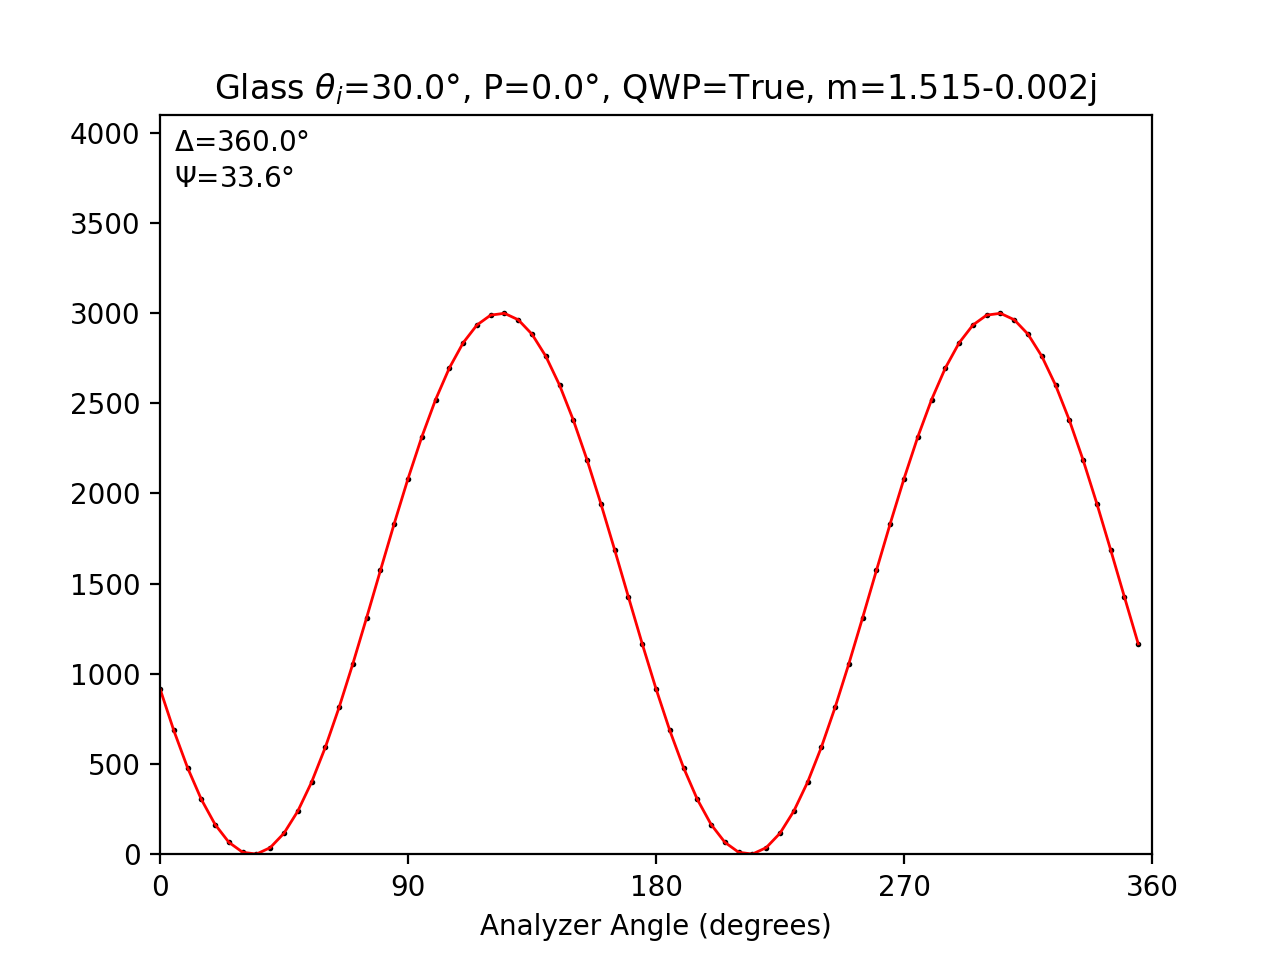

In [2]:
N=5
I=30
P=0
QWP=True

ydata = np.empty((N,72))
theta_i = np.radians(I)
theta_p = np.radians(P)

def update(frame, theta_i, theta_p, QWP):
    i = frame % N
    rho = ell.rho_from_m(m_bk7, theta_i)

    ydata[i] = fake_signal(phi, rho, theta_p, QWP=QWP)
    
    lo = np.min(ydata,axis=0)
    hi = np.max(ydata,axis=0)
    signal = np.mean(ydata,axis=0)
    
    rho, fit = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p, QWP=QWP)
    tanpsi, Delta = ell.tanpsi_Delta_from_rho(rho)
    DeltaD = np.degrees(Delta)
    psiD = np.degrees(np.arctan(tanpsi))
    m = ell.m_from_rho(rho, theta_i)
    
    lines[0].set_data(phiD, signal)
    lines[1].set_data(phiD, fit)

    ax.collections.clear()
    ax.fill_between(phiD, lo, hi, facecolor='blue', alpha=0.2)
    str = r"Glass $\theta_i$=%.1f°, P=%.1f°, QWP=%r, m=%.3f%+.3fj" % (I,P,QWP,m.real,m.imag)
    Delta_label.set_text(r"$\Delta$=%.1f°" % DeltaD)
    Psi_label.set_text(r"$\Psi$=%.1f°" % psiD)

    ax.set_title(str)
    return lines


fig = plt.figure()
ax = plt.axes(xlim=(0, 360), ylim=(0,4096))
Delta_label = ax.text(5,3900,r"$\Delta$")
Psi_label = ax.text(5,3700,r'$\psi')
plt.xlabel('Analyzer Angle (degrees)')
plt.xticks([0,90,180,270,360])

# set up the lines that will be dynamically updated
lines = [ax.plot([],[],'ko',markersize=1)[0],
         ax.plot([],[],'r',lw=1)[0],
        ]

ani = animation.FuncAnimation(fig, update, interval=500, fargs=[theta_i, theta_p, QWP])


<IPython.core.display.Javascript object>


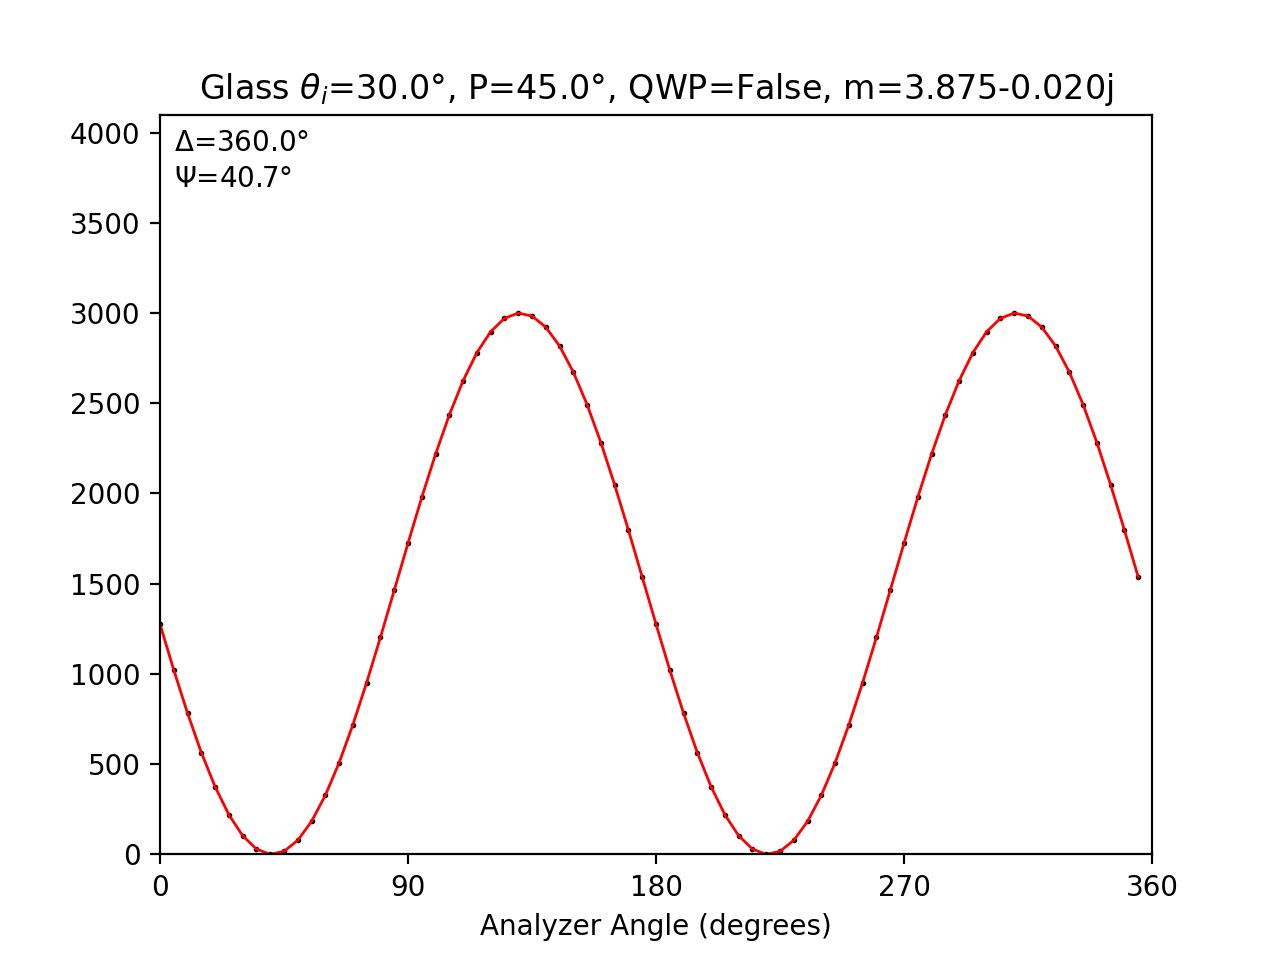

In [3]:
N=5
I=30
P=45
QWP=False

ydata = np.empty((N,72))
theta_i = np.radians(I)
theta_p = np.radians(P)

def update(frame, theta_i, theta_p, QWP):
    i = frame % N
    rho = ell.rho_from_m(m_si, theta_i)

    ydata[i] = fake_signal(phi, rho, theta_p, QWP=QWP)
    
    lo = np.min(ydata,axis=0)
    hi = np.max(ydata,axis=0)
    signal = np.mean(ydata,axis=0)
    
    rho, fit = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p, QWP=QWP)
    tanpsi, Delta = ell.tanpsi_Delta_from_rho(rho)
    DeltaD = np.degrees(Delta)
    psiD = np.degrees(np.arctan(tanpsi))
    m = ell.m_from_rho(rho, theta_i)
    
    lines[0].set_data(phiD, signal)
    lines[1].set_data(phiD, fit)

    ax.collections.clear()
    ax.fill_between(phiD, lo, hi, facecolor='blue', alpha=0.2)
    str = r"Glass $\theta_i$=%.1f°, P=%.1f°, QWP=%r, m=%.3f%+.3fj" % (I,P,QWP,m.real,m.imag)
    Delta_label.set_text(r"$\Delta$=%.1f°" % DeltaD)
    Psi_label.set_text(r"$\Psi$=%.1f°" % psiD)

    ax.set_title(str)
    return lines


fig = plt.figure()
ax = plt.axes(xlim=(0, 360), ylim=(0,4096))
Delta_label = ax.text(5,3900,r"$\Delta$")
Psi_label = ax.text(5,3700,r'$\psi')
plt.xlabel('Analyzer Angle (degrees)')
plt.xticks([0,90,180,270,360])

# set up the lines that will be dynamically updated
lines = [ax.plot([],[],'ko',markersize=1)[0],
         ax.plot([],[],'r',lw=1)[0],
        ]

ani = animation.FuncAnimation(fig, update, interval=500, fargs=[theta_i, theta_p, QWP])


### Silicon

Again, the average of five ellipsometer readings with **very** low noise and obviously no instrument misalignments.

<IPython.core.display.Javascript object>


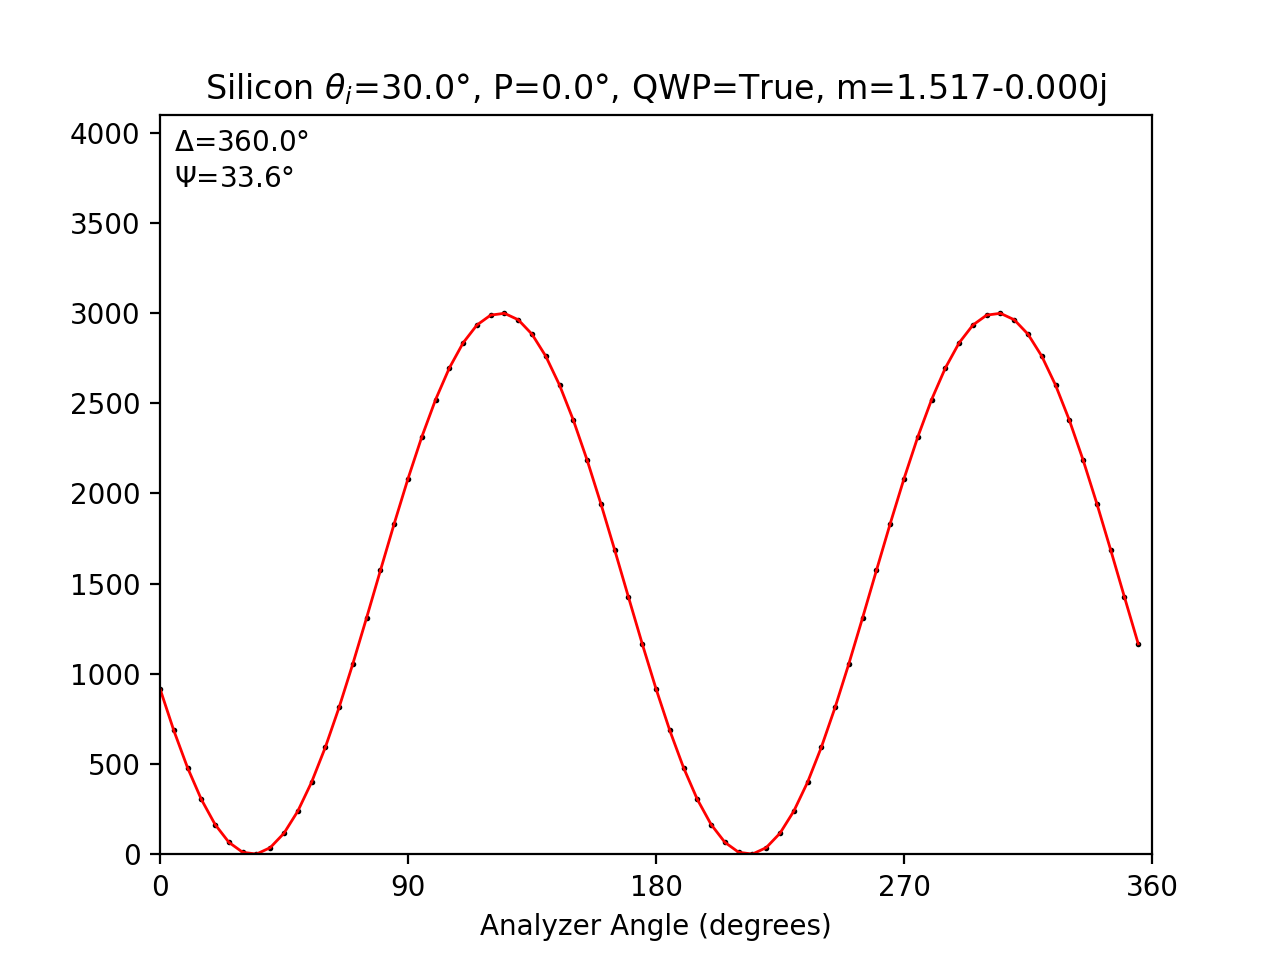

In [4]:
N=5
I=30
P=0
QWP=True

ydata = np.empty((N,72))
theta_i = np.radians(I)
theta_p = np.radians(P)

def update(frame, theta_i, theta_p, QWP):
    i = frame % N
    rho = ell.rho_from_m(m_bk7, theta_i)

    ydata[i] = fake_signal(phi, rho, theta_p, QWP=QWP)
    
    lo = np.min(ydata,axis=0)
    hi = np.max(ydata,axis=0)
    signal = np.mean(ydata,axis=0)
    
    rho, fit = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p, QWP=QWP)
    tanpsi, Delta = ell.tanpsi_Delta_from_rho(rho)
    DeltaD = np.degrees(Delta)
    psiD = np.degrees(np.arctan(tanpsi))
    m = ell.m_from_rho(rho, theta_i)
    
    lines[0].set_data(phiD, signal)
    lines[1].set_data(phiD, fit)

    ax.collections.clear()
    ax.fill_between(phiD, lo, hi, facecolor='blue', alpha=0.2)
    str = r"Silicon $\theta_i$=%.1f°, P=%.1f°, QWP=%r, m=%.3f%+.3fj" % (I,P,QWP,m.real,m.imag)
    Delta_label.set_text(r"$\Delta$=%.1f°" % DeltaD)
    Psi_label.set_text(r"$\Psi$=%.1f°" % psiD)

    ax.set_title(str)
    return lines


fig = plt.figure()
ax = plt.axes(xlim=(0, 360), ylim=(0,4096))
Delta_label = ax.text(5,3900,r"$\Delta$")
Psi_label = ax.text(5,3700,r'$\psi')
plt.xlabel('Analyzer Angle (degrees)')
plt.xticks([0,90,180,270,360])

# set up the lines that will be dynamically updated
lines = [ax.plot([],[],'ko',markersize=1)[0],
         ax.plot([],[],'r',lw=1)[0],
        ]

ani = animation.FuncAnimation(fig, update, interval=500, fargs=[theta_i, theta_p, QWP])


<IPython.core.display.Javascript object>


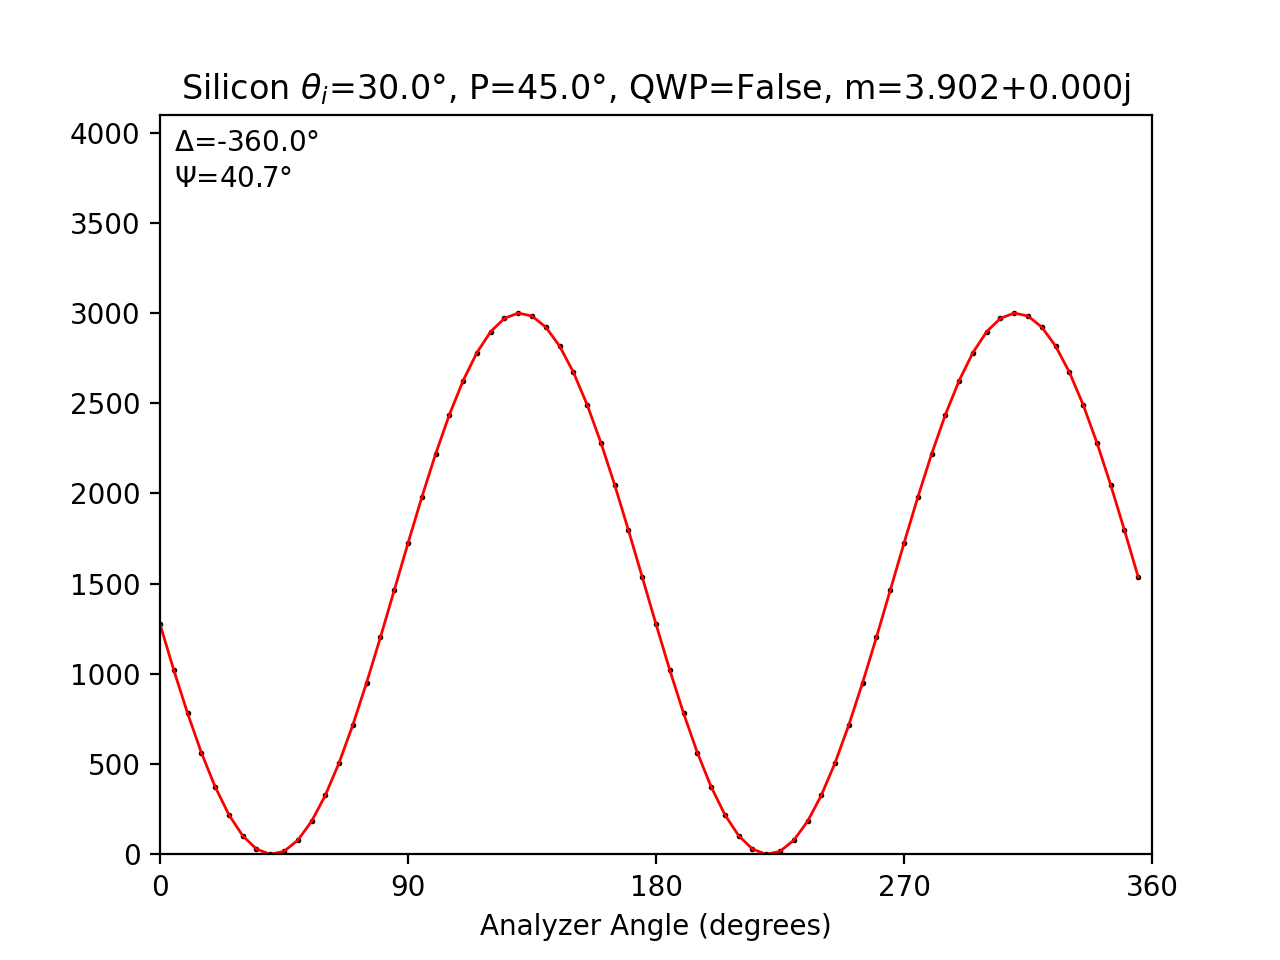

In [5]:
N=5
I=30
P=45
QWP=False

ydata = np.empty((N,72))
theta_i = np.radians(I)
theta_p = np.radians(P)

def update(frame, theta_i, theta_p, QWP):
    i = frame % N
    rho = ell.rho_from_m(m_si, theta_i)

    ydata[i] = fake_signal(phi, rho, theta_p, QWP=QWP)
    
    lo = np.min(ydata,axis=0)
    hi = np.max(ydata,axis=0)
    signal = np.mean(ydata,axis=0)
    
    rho, fit = ell.rho_from_rotating_analyzer_data(phi, signal, theta_p, QWP=QWP)
    tanpsi, Delta = ell.tanpsi_Delta_from_rho(rho)
    DeltaD = np.degrees(Delta)
    psiD = np.degrees(np.arctan(tanpsi))
    m = ell.m_from_rho(rho, theta_i)
    
    lines[0].set_data(phiD, signal)
    lines[1].set_data(phiD, fit)

    ax.collections.clear()
    ax.fill_between(phiD, lo, hi, facecolor='blue', alpha=0.2)
    str = r"Silicon $\theta_i$=%.1f°, P=%.1f°, QWP=%r, m=%.3f%+.3fj" % (I,P,QWP,m.real,m.imag)
    Delta_label.set_text(r"$\Delta$=%.1f°" % DeltaD)
    Psi_label.set_text(r"$\Psi$=%.1f°" % psiD)

    ax.set_title(str)
    return lines


fig = plt.figure()
ax = plt.axes(xlim=(0, 360), ylim=(0,4096))
Delta_label = ax.text(5,3900,r"$\Delta$")
Psi_label = ax.text(5,3700,r'$\psi')
plt.xlabel('Analyzer Angle (degrees)')
plt.xticks([0,90,180,270,360])

# set up the lines that will be dynamically updated
lines = [ax.plot([],[],'ko',markersize=1)[0],
         ax.plot([],[],'r',lw=1)[0],
        ]

ani = animation.FuncAnimation(fig, update, interval=500, fargs=[theta_i, theta_p, QWP])


## Real data

Here are some measurements on a silicon wafer and glass at 632.8nm.  The incidence angle is 30°.  Two experiments were done for each material.

No QWP, $\theta_p$ = 45°

QWP at 45°, $\theta_p$ = 0°

The ellipsometer has been poorly aligned (the two peak heights should be within 0.1% of each other.  Furthermore, the measurement on glass will

<IPython.core.display.Javascript object>


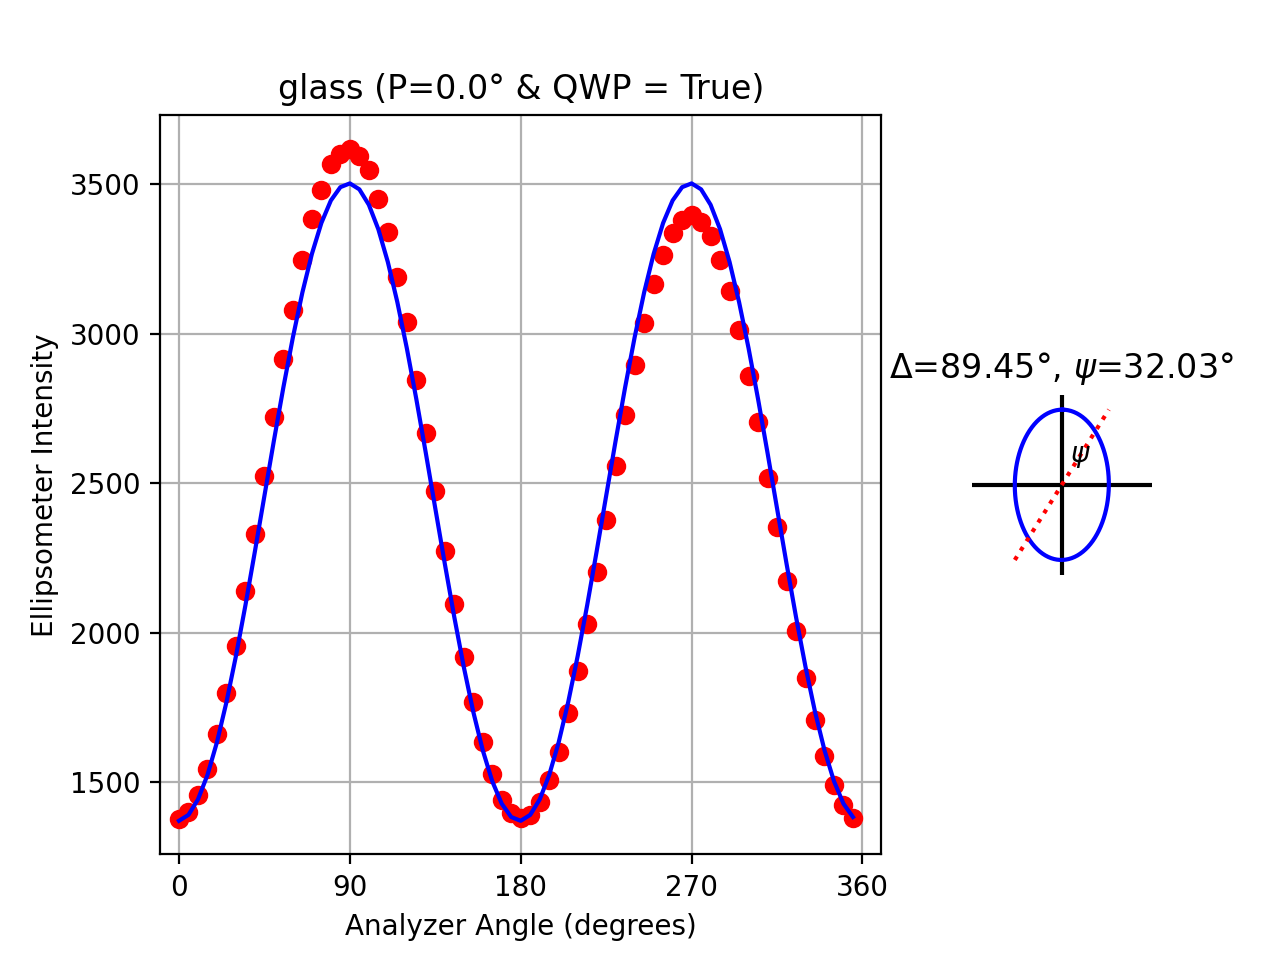

<IPython.core.display.Javascript object>


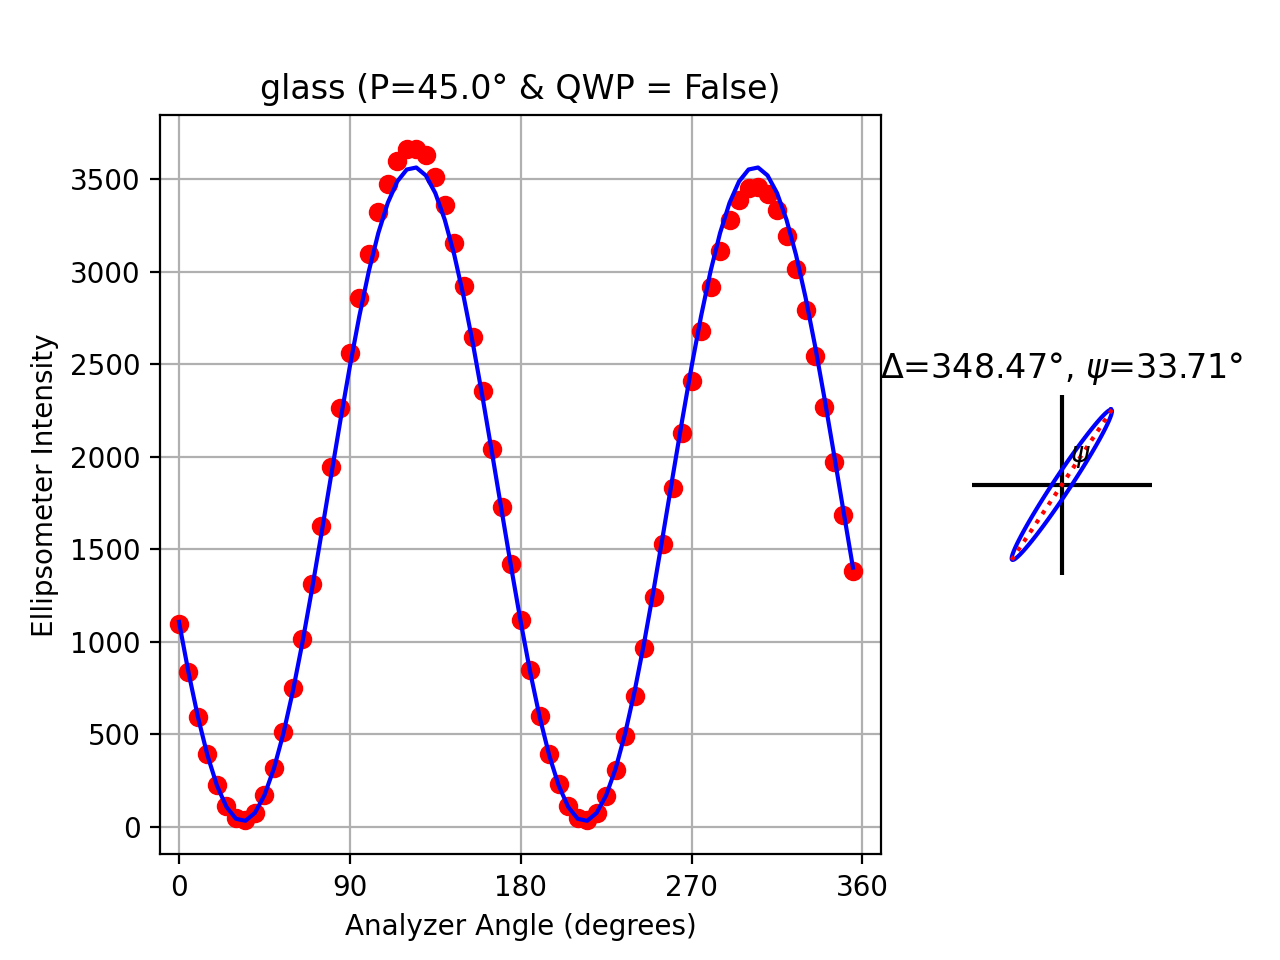

In [6]:
show_fit_and_ellipse("glass",phi,bk7_30_00_1,np.radians(0),True)
show_fit_and_ellipse("glass",phi,bk7_30_45_0,np.radians(45),False)

<IPython.core.display.Javascript object>


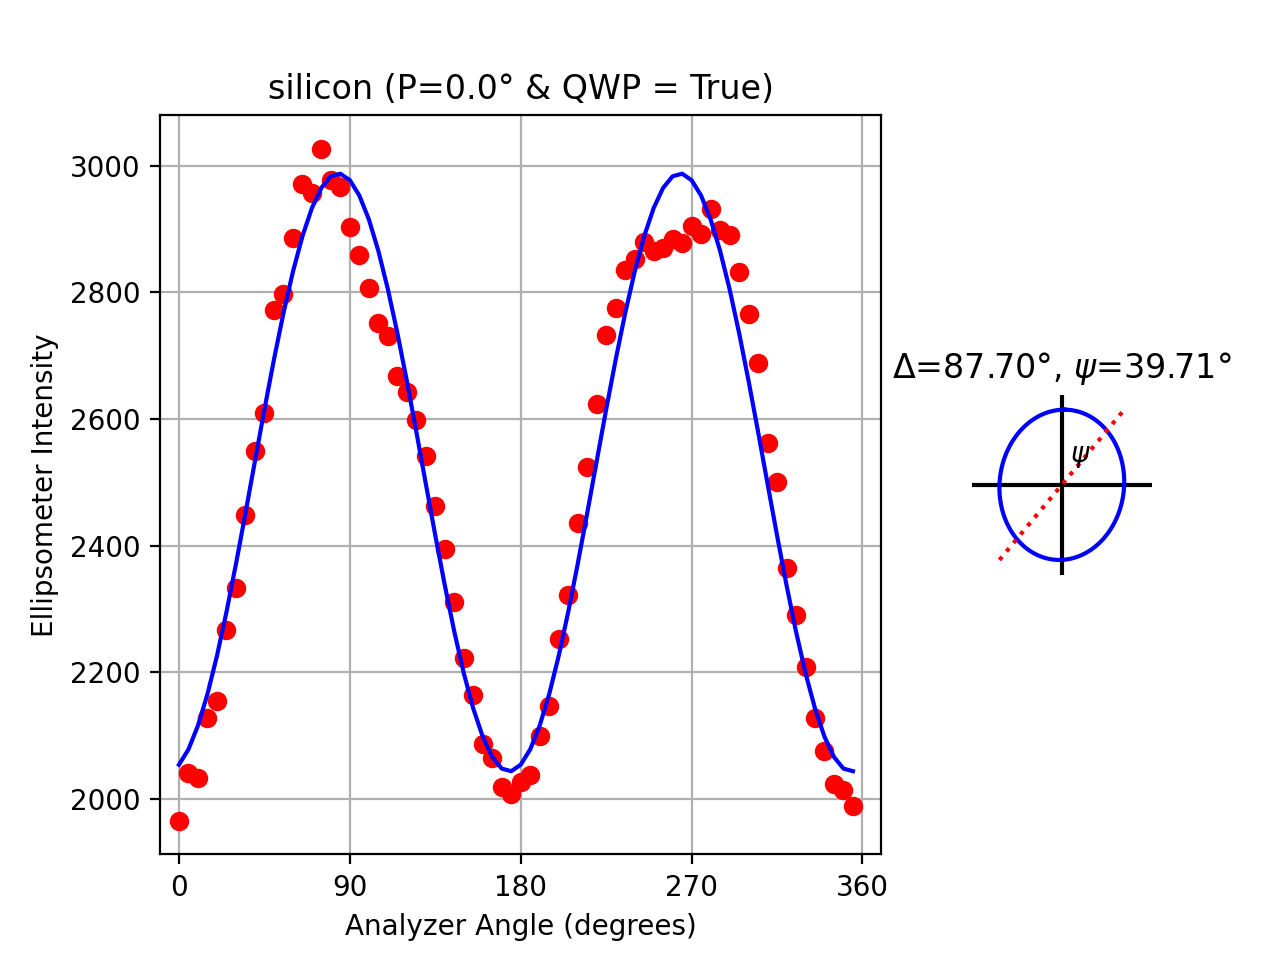

<IPython.core.display.Javascript object>


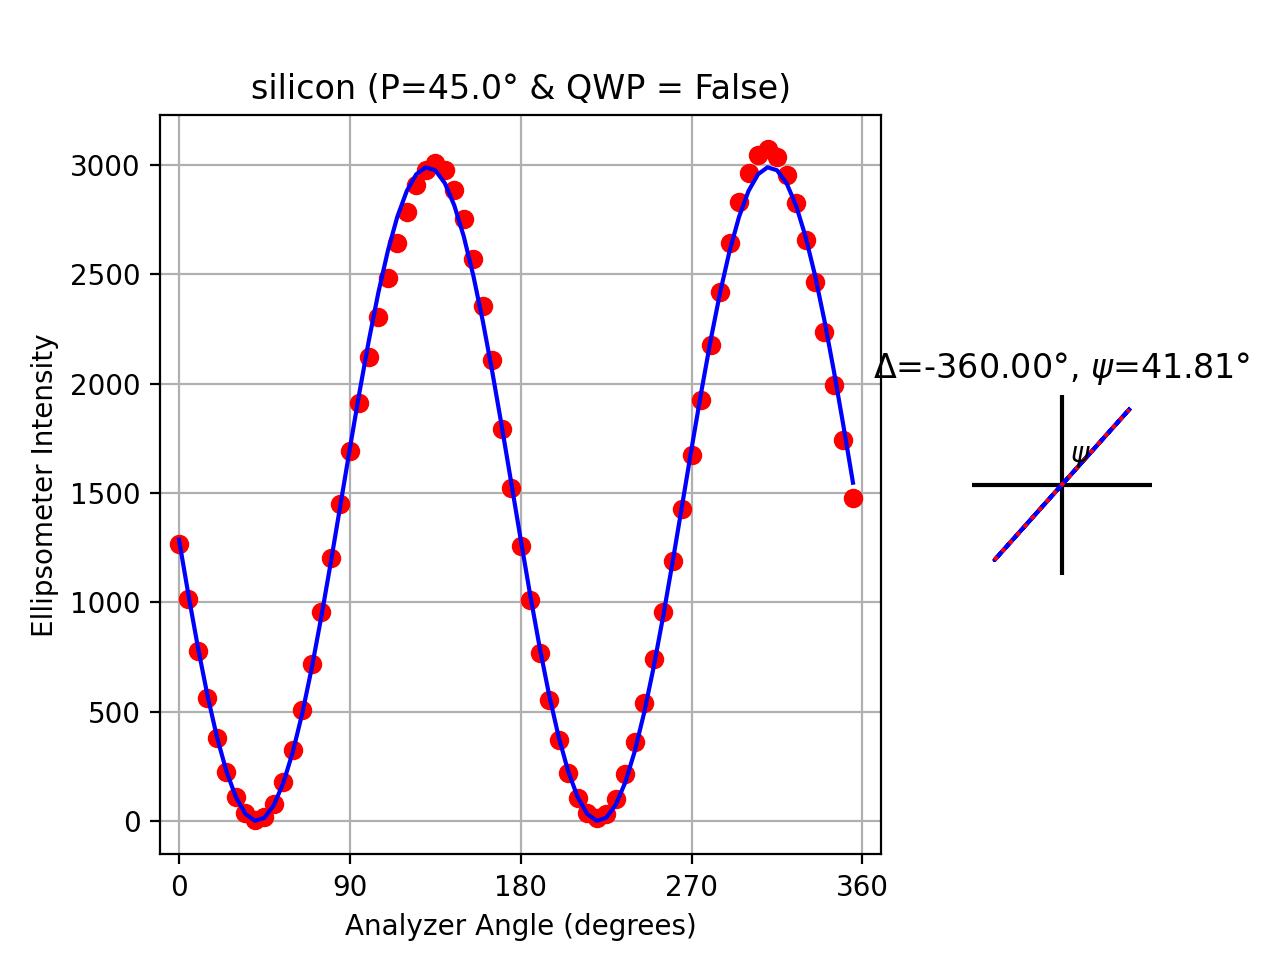

In [7]:
show_fit_and_ellipse("silicon",phi,si_30_00_1,np.radians(0),True)
show_fit_and_ellipse("silicon",phi,si_30_45_0,np.radians(45),False)

### Establishing a connection to the ellipsometer

You must establish serial communication between your computer and the Arduino.
**To do this you need to know the name of the serial connection.**

One way to figure our the right name is to list the current serial ports on your computer:  `gaerter.current_serial_ports()` returns such a list.

Of course, if the ellipsometer is not plugged into the computer then the proper serial port will not appear.

In [ ]:
s = gaertner.current_serial_ports()
print(s)

Identify the port that is connected to the Arduino.
Copy that portname and port connected to the Ardunio string from above as the correct serial port id below

In [7]:
id = '/dev/cu.usbmodemFA141'   # UPDATE ME

conn = gaertner.connect_to_ellipsometer(id)

ERROR: serial port '/dev/cu.usbmodemFA141' is disconnected


### Obtaining a signal

To acquire 72 equally spaced measurements as the analyzer is rotated, just do
```
signal=get_reflectance(conn)
```

## 30° incidence angle

### Glass

In [ ]:
# glass, polarizer at 45°, no QWP, theta_i=30°
QWP=False
P = np.radians(45)
theta_i = np.radians(30)

signal = gaertner.avg_reflectance(conn)
rho, fit = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=QWP)
m = ell.m_from_rho(rho,theta_i)

plt.plot(phiD, signal, 'bo')
plt.plot(phiD, fit, 'r')
plt.title("m=%.4f%+.4fj" % (m.real,m.imag))
plt.show()

In [ ]:
# save if it looks good (gain is set properly, etc.
gaertner.save_data_with_name(signal, "glass", theta_i, P, QWP=QWP)

In [ ]:
# glass, polarizer at 0° with QWP at 45°
QWP=True
P = np.radians(0)
theta_i = np.radians(30)

signal = gaertner.get_reflectance(conn)
rho, fit = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=QWP)
m = ell.m_from_rho(rho,theta_i)

plt.plot(phiD, signal, 'bo')
plt.plot(phiD, fit, 'r')
plt.title("m=%.4f%+.4fj" % (m.real,m.imag))
plt.show()

In [ ]:
# save if it looks good (gain is set properly, etc.
gaertner.save_data_with_name(signal, "glass", theta_i, P, QWP=QWP)

### Silicon

In [ ]:
# silicon, polarizer at 45°, no QWP, theta_i=30°
QWP=False
P = np.radians(45)
theta_i = np.radians(30)

signal = gaertner.get_reflectance(conn)
rho, fit = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=QWP)
m = ell.m_from_rho(rho,theta_i)

plt.plot(phiD, signal, 'bo')
plt.plot(phiD, fit, 'r')
plt.title("m=%.4f%+.4fj" % (m.real,m.imag))
plt.show()

In [ ]:
# save if it looks good (gain is set properly, etc.
gaertner.save_data_with_name(signal, "silicon", theta_i, P, QWP=QWP)

In [ ]:
# silicon, polarizer at 0° with QWP at 45°
QWP = True
P = np.radians(0)
theta_i = np.radians(30)

signal = gaertner.get_reflectance(conn)
rho, fit = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=QWP)
m = ell.m_from_rho(rho,theta_i)

plt.plot(phiD, signal, 'bo')
plt.plot(phiD, fit, 'r')
plt.title("m=%.4f%+.4fj" % (m.real,m.imag))
plt.show()

In [ ]:
# save if it looks good (gain is set properly, etc.
gaertner.save_data_with_name(signal, "silicon", theta_i, P, QWP=QWP)